In [1]:
import os
import torch
from collections import Counter, OrderedDict
from operator import itemgetter
import random
from random import sample
import numpy as np
import json
from collections import OrderedDict
import pickle
import matplotlib.pylab as plt
from functools import partial
import pprint
import hashlib
import copy
import sys
import math
from copy import deepcopy
import hashlib
import uuid 
import ast
# Baby-ARC related imports
from constants import *
from utils import *
from objects import *
from operator import *
from canvas import *
from dataset import *
from itertools import product
import re
# random seeds
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# global vars
RUN_AS_CREATOR = False
ARC_OBJ_LOADED = False
DEMO_MAX_ARC_OBJS = 500
pp = pprint.PrettyPrinter(indent=4)

import logging
FORMAT = "%(asctime)-15s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.DEBUG,
                    datefmt="%Y-%m-%d %H:%M")
logger = logging.getLogger(__name__)

if RUN_AS_CREATOR:
    logger.info("WARNING: You are using this a creator of BabyARC, it assumes you install all dependencies!")
    logger.info("If you are not the creator, please disable this. All functionalities of recreating the dataset is still here!")

### Collect Objects from the ARC dataset
**WARNING:** This will fail, please use our pre-collected arc object files. We made this avaliable. The process of making this file involves hidden logics which will not be revealed. Currently, you can treat it as just a set of generated object pool!

Details about the ARC can be found: https://github.com/fchollet/ARC. Note that you only have to run this one time, it will generate a file and save to the output directory. Later, you can simply use it! 

In [2]:
if RUN_AS_CREATOR:
    training_objs = []
    for filename in os.listdir(arc_data_train_path):
        if filename.endswith(".json"):
            print("extracting objs from task: ", filename)
            training_objs.extend(single_task_obj_parser(filename.split(".")[0]))
    # we only need to parse once, and save it to the disk
    torch.save(training_objs, os.path.join(tmp_data_dirname, 'arc_objs.pt'))
else:
    try:
        arc_objs = torch.load(os.path.join(tmp_data_dirname, 'arc_objs.pt'))
        logger.info("SUCCESS! You loaded the pre-collected object file from ARC!")
        ARC_OBJ_LOADED = True
    except:
        logger.info("Please check if obejct file in the directory indicated above!")
        logger.info(f"WARNING: Please get those pre-collected ARC objects in {os.path.join(tmp_data_dirname, 'arc_objs.pt')}!")
        logger.info("You can download this file from: https://drive.google.com/file/d/1dZhT1cUFGvivJbSTwnqjou2uilLXffGY/view?usp=sharing")

2021-03-21 22:29 SUCCESS! You loaded the pre-collected object file from ARC!


### Pre-checks before moving forward with the Demo!

These are some prechecks we enforced to ensure good user experience with this Demo! Please make sure you pass the test!

In [3]:
if not ARC_OBJ_LOADED or RUN_AS_CREATOR:
    logger.info("FAILED! Resolve issues before moving forward with this Demo file!")
else:
    logger.info("PASSED!")

2021-03-21 22:29 PASSED!


### Object Engine

In [4]:
ObE = ObjectEngine(arc_objs[:DEMO_MAX_ARC_OBJS])
# Below the log, it should shows how many objects it loads.
# Iso obj means the count of unique objects (considering rotations, color permutations, etc..)
_ = ObE.sample_objs_by_fixed_width()
# If no error, that means you successfully sampled an object!

2021-03-21 22:29 Original obj count = 500
2021-03-21 22:29 Iso obj count = 51


### Canvas Engine
You can now place different objects based on different relations if provided on the Canvas!

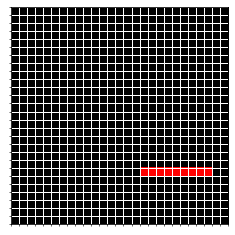

In [5]:
test_canvas = CanvasEngine().sameple_canvas()[0]
objs1 = ObE.sample_objs_with_line(n=1, len_lims=[5,10], thickness=1, rainbow_prob=0.1, direction="h")
# Here is just one example with how you can sample different objects from the object engine!
results = test_canvas.placement(objs1[0])
if results == -1:
    logger.info("Placement step failed! Please rerun!")
else:
    test_canvas.render(minimum_cover=False)

Placement with object relations.

OrderedDict([((0, 'color_[9]'), 'Attr'),
             ((0, 'pos_[3,14]'), 'Attr'),
             ((1, 'pos_[1,10]'), 'Attr'),
             ((0, 1), 'IsInside')])

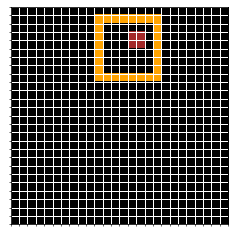

In [8]:
test_canvas = CanvasEngine().sameple_canvas()[0]
objs1 = ObE.sample_objs_by_bound_area(n=1, rainbow_prob=0.2, 
                                      w_lim=3, h_lim=3)
_ = test_canvas.render(minimum_cover=False)
results = test_canvas.placement(objs1[0])
if results == -1:
    logger.info("Placement step failed! Please rerun!")
else:
    objs2 = ObE.sample_objs_with_reactangle(n=1, thickness=1, rainbow_prob=0.3, 
                                              w_lims=[8,8], h_lims=[8,8])
    results = test_canvas.placement(objs2[0], to_relate_objs=[0], placement_rule="IsOutside")
    if results == -1:
        logger.info("Placement step failed! Please rerun!")
    else:
        test_canvas.render(minimum_cover=False)
        
test_canvas.parse_relations() # this also parse the relations for your automatically!

### BabyARC Canvas
This is the dataset class where you can sample canvas in a much higher level!

In [5]:
demo_dataset = \
    BabyARCDataset(pretrained_obj_cache=os.path.join(tmp_data_dirname, 'arc_objs.pt'),
                   save_directory="./BabyARCDataset/", 
                   object_limit=500, noise_level=0)

2021-03-21 22:29 Creating new BabyARC dataset by loading in pretrained objects.
2021-03-21 22:29 Loading the object engine and canvas engine with a limit of object number {object_limit}, background_color={int(dataset_background_color)}.
2021-03-21 22:29 Original obj count = 500
2021-03-21 22:29 Iso obj count = 51


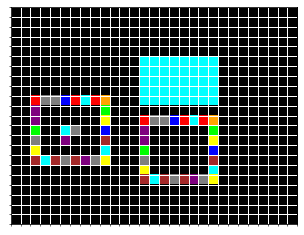

In [17]:
canvas_dict = demo_dataset.sample_single_canvas_by_core_edges(
    OrderedDict([(('obj_0', 'obj_1'), 'IsInside'), 
                 (('obj_2', 'obj_1'), 'SameAll'), 
                 (('obj_2', 'obj_3'), 'SameCol')]))

In [18]:
canvas_dict

OrderedDict([('id_object_map',
              OrderedDict([(0,
                            tensor([[2., 5., 5., 1., 2., 8., 2., 7.],
                                    [6., 0., 0., 0., 0., 0., 0., 3.],
                                    [6., 0., 0., 0., 0., 0., 0., 4.],
                                    [3., 0., 0., 0., 0., 0., 0., 1.],
                                    [5., 0., 0., 0., 0., 0., 0., 9.],
                                    [4., 0., 0., 0., 0., 0., 0., 8.],
                                    [9., 8., 9., 5., 9., 6., 5., 4.]])),
                           (1,
                            tensor([[8., 5.],
                                    [6., 0.]])),
                           (2,
                            tensor([[2., 5., 5., 1., 2., 8., 2., 7.],
                                    [6., 0., 0., 0., 0., 0., 0., 3.],
                                    [6., 0., 0., 0., 0., 0., 0., 4.],
                                    [3., 0., 0., 0., 0., 0., 0., 1.],
        

### Operators


In [250]:
class OperatorEngine(object):
    
    def __init__(self):
        
        # DSLs for operators
        self.ARG_TYPES = {"$OBJ", "$NUMERIC", "$WHOLE", "$POSITION"} # <- produced by selector
        self.OPERATORS = {
            "@IDENTITY" : "$OBJ|$WHOLE",
            "@ROTATION" : "$OBJ|$WHOLE", # this rotation contains flip as well!
            # "@DRAWLINE" : "$POSITION&$POSITION&$NUMERIC",
            "@DRAW" : "$OBJ&$NUMERIC|$POSITION&$NUMERIC|$NUMERIC",
            # "@DRAWPATTERN" : "$POSITION&$NUMERIC",
            # "@MOVE" : "$OBJ&$POSITION",
            # "@REMAINDER" : "$OBJ",
            # "@SORT" : "$OBJ&$NUMERIC",
            "@OUT" : "$OBJ|$WHOLE",
            "@IN" : "$WHOLE"
        }
        self.SELECTORS = {
            "$OBJ" : ["$SELECTOR_PATTERN", "$SELECTOR_ALL", "$SELECTOR_EXTREME"], 
            "$WHOLE" : ["$SELECTOR_WHOLE"],
            "$NUMERIC" : ["$OBJ^$SELECTOR_COLOR_COUNT", "$OBJ^$SELECTOR_OBJ_COUNT", 
                          "$OBJ^$SELECTOR_PIXEL_COUNT", "$OBJ^$SELECTOR_COLOR", 
                          "$OBJ^$SELECTOR_RANDOM", "$OBJ^$SELECTOR_PARTIAL_POSITION"],
            "$POSITION" : ["$OBJ^$SELECTOR_POSITION"]
        }
        
        for selector, patterns in self.SELECTORS.items():
            new_patterns = []
            for p in patterns:
                if "^" in p:
                    
                    # high order selector, assumes it goes only second order!
                    p = p.split("^")
                    for ele in self.SELECTORS[p[0]]:
                        new_patterns.append(f"{ele}^{p[-1]}")
                else:
                    new_patterns.append(p)
            self.SELECTORS[selector] = new_patterns
    
    def get_relation_nbrs(self, node, edges):
        for k, v in edges.items():
            if k[0] == node:
                if v == "Attr":
                    yield (k[1], v)
                else:
                    yield (v,)

    def dfs_path_helper(self, curr_node, curr_path, result, edges, k=3):
        if len(curr_path) != 0:
            result.add(tuple(copy.deepcopy(curr_path)))
        if len(curr_path) == 3:
            return
        
        for nbr in self.get_relation_nbrs(curr_node, edges):
            if nbr not in curr_path:
                curr_path.append(nbr)
                self.dfs_path_helper(nbr, curr_path, result, edges, k=k)
                curr_path.pop()
        
    def dfs_path(self, root, edges, k=3):
        results = set([])
        self.dfs_path_helper(root, [], results, edges, k=k)
        return results
    
    def _consolidate_patterns_within_canvas(self, obj_paths):
        reversed_patterns = OrderedDict({})
        object_pool = []
        for k, _ in obj_paths.items():
            object_pool.append(k)

        for i in range(len(object_pool)):
            obj_i = object_pool[i]
            obj_i_path = obj_paths[obj_i]
            for path in obj_i_path:
                matched = False
                for k, v in reversed_patterns.items():
                    # consolidate in
                    if k == path:
                        reversed_patterns[path].add(obj_i[0]) # this is only for a single obj
                        matched = True
                        break
                # adding this to the reversed pattern mapping as well
                if not matched:
                    reversed_patterns[path] = set([obj_i[0]])
        return reversed_patterns
    
    def get_obj_dfs_path(self, canvas, k=3):
        # extrapolate the relation to be bidirectional for all relations
        relation_edges = canvas.partial_relation_edges
        relation_edges_copy = copy.deepcopy(relation_edges)
        for k, v in relation_edges.items():
            if v != "Attr" and v != "IsInside": # IsInside is not permutable here!
                relation_edges_copy[(k[1], k[0])] = v
        parsed_relation_edges = canvas.parse_relations()
        for k, v in parsed_relation_edges.items():
            if v == "Attr":
                relation_edges_copy[(canvas.id_node_map[k[0]], k[1])] = v
            else:
                relation_edges_copy[(canvas.id_node_map[k[0]], canvas.id_node_map[k[1]])] = v
        
        # loop through each obj
        obj_paths = OrderedDict({})
        common_in = None
        for k, v in canvas.id_node_map.items():
            v_paths = self.dfs_path(v, relation_edges_copy, k=k)
            if common_in == None:
                common_in = v_paths
            else:
                common_in = common_in.intersection(v_paths)
            obj_paths[tuple([v])] = v_paths
        for k, v in obj_paths.items():
            obj_paths[k] = v - common_in
        return self._consolidate_patterns_within_canvas(obj_paths) # return consolidated paths

    def _sample_operator_combination(self, k=2, middle=True):
        avaliable_operators = set(list(self.OPERATORS.keys()))
        if middle:
            avaliable_operators = avaliable_operators - {"@OUT", "@IN"}
        if k > 1:
            avaliable_operators = avaliable_operators - {"@COMBINED", "@REMAINDER", "@SORT"}
        existing_operators = list(avaliable_operators)
        operator_permutator = []
        for i in range(k):
            operator_permutator.append(copy.deepcopy(existing_operators))
        operator_permutations = product(*operator_permutator)
        operator_combinations = []
        for perm in operator_permutations:
            if len(set(perm)) == len(perm): # non-repeat
                operator_combinations.append(perm)
        return operator_combinations 
    
    def _graph_convertor(self, flatten_graph):
        graph = OrderedDict({})
        for k, v in flatten_graph.items():
            if v in graph.keys():
                graph[v].append(k)
            else:
                graph[v] = [k]
        return graph

    def sample_operator_graph(self, max_ops_depth=3):
        operator_graphs = []
        avaliable_operators = set(list(self.OPERATORS.keys()))
        avaliable_operators = avaliable_operators - {"@OUT", "@IN"}
        op_graph_pemutator = []
        for i in range(max_ops_depth):
            op_graph_pemutator.append(copy.deepcopy(list(avaliable_operators)))
        op_graphs = product(*op_graph_pemutator)
        for op_g in op_graphs:
            args_permutator = []
            for steps in op_g:
                step_args = self.OPERATORS[steps].split("|") # there could be potentially multiple args
                                                             # supported for this ops
                args_permutator.append(step_args)
            args_permutations = product(*args_permutator)
            for step_args in args_permutations:
                step_idx = 1
                curr_step_permutator = []
                for s_a in step_args:
                    step_perms = []
                    s_a = s_a.split("&")
                    
                    # get all the s_a combinations
                    s_a_permutators = []
                    for s_a_s in s_a:
                        s_a_permutators.append(self.SELECTORS[s_a_s])
                    s_a_permutations = product(*s_a_permutators)
                    for s_a_perm in s_a_permutations:
                        # potential output connecting points
                        out_in = []
                        for i in range(step_idx):
                            out_in.append(f"{i}$OUT")
                        out_permutator = []
                        for j in range(len(s_a_perm)):
                            out_permutator.append(out_in)
                        out_permutations = product(*out_permutator)
                        for out_perm in out_permutations:
                            v = op_g[step_idx-1]
                            for combo in zip(out_perm, s_a_perm):
                                v += f" {combo[0]}^{combo[1]}"
                            if f"{step_idx-1}$OUT" in v:
                                step_perms.append(v) # you need to include last one!
                    curr_step_permutator.append(step_perms)
                    step_idx += 1
                curr_step_permutations = product(*curr_step_permutator)
                for c_s_p in curr_step_permutations:
                    graph = OrderedDict({})
                    graph["0$OUT"] = "@IDENTITY 0$IN"
                    for i in range(len(c_s_p)):
                        graph[f"{i+1}$OUT"] = c_s_p[i]
                    if graph[f"{len(c_s_p)}$OUT"].split(" ")[0] == "@IDENTITY" and \
                        "^".join(graph[f"{len(c_s_p)}$OUT"].split("^")[1:]) in self.SELECTORS["$NUMERIC"]:
                        graph[f"{len(c_s_p)+1}$OUT"] = f"@DRAW {len(c_s_p)}$OUT"
                        operator_graphs.append(copy.deepcopy(graph))
                    else:
                        for o_perm in self.SELECTORS["$OBJ"]+self.SELECTORS["$WHOLE"]:
                            graph[f"{len(c_s_p)+1}$OUT"] = f"@IDENTITY {len(c_s_p)}$OUT^{o_perm}"
                            operator_graphs.append(copy.deepcopy(graph))
        return operator_graphs
    
    def _count_image_t_pixel(self, image_t, background_color=0):
        count = 0
        for i in range(image_t.shape[0]):
            for j in range(image_t.shape[1]):
                if image_t[i,j] != background_color:
                    count += 1
        return count
    
    def _generate_ranking_tuples(self, canvas, rank_by="#POS_COL"): # output single object
        ranking_tuples = []
        for k, v in canvas.node_id_map.items():
            position_t = canvas.opos_map[v]
            row = position_t[0]
            col = position_t[1]
            obj = canvas.oid_map[v]
            h = obj.image_t.shape[0]
            w = obj.image_t.shape[1]
            c_h = canvas.init_canvas.shape[0]
            c_w = canvas.init_canvas.shape[1]
            if rank_by == "#POS_COL":
                ranking_tuples.append((k, col))
            elif rank_by == "#POS_COL_R":
                ranking_tuples.append((k, c_w-(col+w)))
            elif rank_by == "#POS_ROW":
                ranking_tuples.append((k, row))
            elif rank_by == "#POS_ROW_R":
                ranking_tuples.append((k, c_h-(row+h)))
            elif rank_by == "#AREA":
                ranking_tuples.append((k, h*w))
            elif rank_by == "#WIDTH":
                ranking_tuples.append((k, w))
            elif rank_by == "#HEIGHT":
                ranking_tuples.append((k, h))
            elif rank_by == "#COUNT_PIXEL":
                ranking_tuples.append((k, self._count_image_t_pixel(obj.image_t, canvas.background_color)))
        
        return sorted(ranking_tuples, key=itemgetter(1))

    def _rotate_tag(self, original_tags, n):
        """
        rotate the tag ccw
        """
        curr_position_tags = copy.deepcopy(original_tags)
        for i in range(n):
            new_position_tags = []
            for t in curr_position_tags:
                if t == "upper":
                    new_position_tags.append("left")
                elif t == "left":
                    new_position_tags.append("lower")
                elif t == "lower":
                    new_position_tags.append("right")
                elif t == "right":
                    new_position_tags.append("upper")
                else:
                    pass
            curr_position_tags = copy.deepcopy(new_position_tags) # recurrent
        return curr_position_tags
    
    def _flip_tag(self, original_tags, direction):
        curr_position_tags = copy.deepcopy(original_tags)
        if direction == -1:
            new_position_tags = []
            for t in curr_position_tags:
                if t == "left":
                    new_position_tags.append("right")
                elif t == "right":
                    new_position_tags.append("left")
                else:
                    new_position_tags.append(t)
        elif direction == -2:
            new_position_tags = []
            for t in curr_position_tags:
                if t == "upper":
                    new_position_tags.append("lower")
                elif t == "lower":
                    new_position_tags.append("upper")
                else:
                    new_position_tags.append(t)
        return new_position_tags

    def _rotation_obj(self, img_obj, rotation):
        ret = copy.deepcopy(img_obj)
        # update image and tag
        if rotation == 0:
            ret.image_t = ret.image_t.flip(-1)
            ret.position_tags = self._flip_tag(ret.position_tags, -1)
        elif rotation == 1:
            ret.image_t = ret.image_t.flip(-2)
            ret.position_tags = self._flip_tag(ret.position_tags, -2)
        elif rotation == 2:
            ret.image_t = torch.rot90(ret.image_t, k=1, dims=(-2, -1))
            ret.position_tags = self._rotate_tag(ret.position_tags, 1)
        elif rotation == 3:
            ret.image_t = torch.rot90(ret.image_t, k=2, dims=(-2, -1))
            ret.position_tags = self._rotate_tag(ret.position_tags, 2)
        elif rotation == 4:
            ret.image_t = torch.rot90(ret.image_t, k=3, dims=(-2, -1))
            ret.position_tags = self._rotate_tag(ret.position_tags, 3)
        elif rotation == 5:
            ret.image_t = torch.rot90(ret.image_t, k=1, dims=(-2, -1)).flip(-1)
            ret.position_tags = self._flip_tag(self._rotate_tag(ret.position_tags, 1), -1)
        elif rotation == 6:
            ret.image_t = torch.rot90(ret.image_t, k=1, dims=(-2, -1)).flip(-2)
            ret.position_tags = self._flip_tag(self._rotate_tag(ret.position_tags, 1), -2)
        else:
            pass
        return ret
    
    def _rotate_img_t(self, img_t_in, rotation):
        img_t = copy.deepcopy(img_t_in)
        if rotation == 0:
            img_t = img_t.flip(-1)
        elif rotation == 1:
            img_t = img_t.flip(-2)
        elif rotation == 2:
            img_t = torch.rot90(img_t, k=1, dims=(-2, -1))
        elif rotation == 3:
            img_t = torch.rot90(img_t, k=2, dims=(-2, -1))
        elif rotation == 4:
            img_t = torch.rot90(img_t, k=3, dims=(-2, -1))
        elif rotation == 5:
            img_t = torch.rot90(img_t, k=1, dims=(-2, -1)).flip(-1)
        elif rotation == 6:
            img_t = torch.rot90(img_t, k=1, dims=(-2, -1)).flip(-2)
        else:
            pass
        return img_t
    
    def _rotate_whole_obj_position(self, canvas_t_in, obj_t_in, old_pos_in, rotation, background_color):
        canvas_t = copy.deepcopy(canvas_t_in)
        obj_t = copy.deepcopy(obj_t_in)
        old_pos = copy.deepcopy(old_pos_in)
        for i in range(obj_t.shape[0]):
            for j in range(obj_t.shape[1]):
                r = old_pos[0] + i
                c = old_pos[1] + j
                canvas_t[r,c] = 1.0
        canvas_t = self._rotate_img_t(canvas_t, rotation)
        for i in range(canvas_t.shape[0]):
            for j in range(canvas_t.shape[1]):
                if canvas_t[i,j] != background_color:
                    return torch.tensor([i,j])
    
    def _rotate_whole(self, canvas, rotation):
        new_canvas = copy.deepcopy(canvas)
        new_init_canvas = self._rotate_img_t(new_canvas.init_canvas, rotation)
        new_canvas.init_canvas = new_init_canvas
        for oid, obj in new_canvas.oid_map.items():
            rotated_obj = self._rotation_obj(obj, rotation)
            new_canvas.oid_map[oid] = rotated_obj
            # then we need to find the new position on the new canvas!
            new_pos = \
                self._rotate_whole_obj_position(canvas.init_canvas, obj.image_t, canvas.opos_map[oid],
                                                rotation,
                                                canvas.background_color)
            new_canvas.opos_map[oid] = new_pos
        return new_canvas
    
    def _rotate_obj_position(self, obj_t_in, old_pos_in, rotation):
        """
        Rotate by the center of the object.
        """
        center_r = old_pos_in[0] + int(obj_t_in.shape[0]/2)
        center_c = old_pos_in[1] + int(obj_t_in.shape[1]/2)
        
        new_obj_t = self._rotate_img_t(obj_t_in, rotation)
        new_r = center_r - int(new_obj_t.shape[0]/2)
        new_c = center_c - int(new_obj_t.shape[1]/2)
        
        return torch.tensor([new_r, new_c]), new_obj_t
    
    ########################################
    #
    # Selectors
    #
    ########################################
    def select_by_common_referred_patterns(self, canvas_list):
        """
        extract patterns exist 
        """
        common_referred = None
        for canvas in canvas_list:
            if common_referred == None:
                common_referred = self.get_obj_dfs_path(canvas)
                # turning value into 2d list to contain multiple canvas information
                flatten_common_referred = OrderedDict({})
                for k, v in common_referred.items():
                    flatten_common_referred[k] = [v]
                common_referred = flatten_common_referred
            else:
                new_common_referred = OrderedDict({})
                current_referred = self.get_obj_dfs_path(canvas) # we dont have to flatten it!
                for path_common, objs_common in common_referred.items():
                    for path_current, objs_current in current_referred.items():
                        if path_common == path_current:
                            new_common_referred[path_common] = []
                            new_common_referred[path_common].extend(objs_common)
                            # common path shared across two canvas
                            new_common_referred[path_common].append(objs_current)
                common_referred = copy.deepcopy(new_common_referred)
        selectors = []
        # return potential selectors as a 2d list, same length as the canvas
        for _, v in common_referred.items():
            # we ignore the keys here for significant reasons.
            # we don't want to explicity expose the relations to 
            # users.
            ss = []
            for e in v:
                ss += [list(e)]
            selectors += [ss]
        return selectors

    def select_by_extreme(self, canvas_list):
        extreme_code = {
            0:"#POS_COL",
            1:"#POS_COL_R",
            2:"#POS_ROW",
            3:"#POS_ROW_R",
            4:"#AREA",
            5:"#WIDTH",
            6:"#HEIGHT",
            7:"#COUNT_PIXEL"
        }
        selector_code = random.randint(0, len(list(extreme_code.keys()))-1)
        selectors = []
        min_len = 99
        for canvas in canvas_list:
            selected_objs = self._generate_ranking_tuples(canvas, rank_by=extreme_code[selector_code])
            if len(selected_objs) < min_len:
                min_len = len(selected_objs)
            selectors.append(selected_objs)
        selector_idx = random.randint(0, min_len-1)
        single_selectors = []
        for s in selectors:
            single_selectors.append([s[selector_idx][0]])
        return single_selectors, extreme_code[selector_code]
    
    def select_all(self, canvas_list):
        selectors = []
        for canvas in canvas_list:
            canvas_selector = []
            for k, v in canvas.node_id_map.items():
                canvas_selector.append(k)
            selectors.append(canvas_selector)
        return selectors
    
    ########################################
    #
    # Operators
    #
    ########################################
    def operator_rotate_whole(self, canvas_list, selectors=[], selector_type="$WHOLE"):
        """
        Rotate whole canvas, selector is not needed!
        """
        rotate_code = {
            0:"#FLIP_1",
            1:"#FLIP_2",
            2:"#ROTATE_1",
            3:"#ROTATE_2",
            4:"#ROTATE_3",
            5:"#ROTATE_1^#FLIP_1",
            6:"#ROTATE_1^#FLIP_2",
        }
        selector_code = random.randint(0, len(list(rotate_code.keys()))-1)
        operated_canvas = []
        for canvas in canvas_list:
            new_canvas = self._rotate_whole(canvas, selector_code)
            operated_canvas.append(new_canvas)
        return operated_canvas, rotate_code[selector_code]
    
    def operate_rotate(self, canvas_list, selectors=[], selector_type="$OBJ"):
        rotate_code = {
            0:"#FLIP_1",
            1:"#FLIP_2",
            2:"#ROTATE_1",
            3:"#ROTATE_2",
            4:"#ROTATE_3",
            5:"#ROTATE_1^#FLIP_1",
            6:"#ROTATE_1^#FLIP_2",
        }
        selector_code = random.randint(0, len(list(rotate_code.keys()))-1)
        operated_canvas = []
        canvas_idx = 0
        for canvas in canvas_list:
            new_canvas = copy.deepcopy(canvas)
            for selected_obj in selectors[canvas_idx]:
                _id = canvas.node_id_map[selected_obj]
                old_obj = canvas.oid_map[_id]
                old_pos = canvas.opos_map[_id]
                new_pos, new_obj_img_t = self._rotate_obj_position(old_obj.image_t, old_pos, selector_code)
                new_canvas.oid_map[_id].image_t = new_obj_img_t
                new_canvas.opos_map[_id] = new_pos
            operated_canvas.append(new_canvas)
            canvas_idx += 1
        return operated_canvas, rotate_code[selector_code]
    
    

In [251]:
canvas_new_list, _ = OperatorEngine().operate_rotate([canvas1, canvas2], [["obj_0"], ["obj_1"]])

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 7., 7., 7., 7., 7., 7., 7., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 7., 7., 7., 7., 7., 7., 7., 7.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 7., 7., 7., 7., 7., 7., 7., 7., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 7., 0., 0., 0., 0., 0., 0., 7., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 7., 0., 7., 9., 7., 0

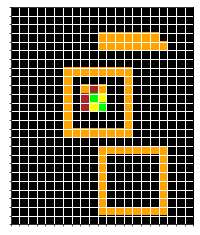

In [252]:
canvas1.render()

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 7., 7., 7., 7., 7., 7., 7., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 7., 7., 7., 7., 7., 7., 7., 7.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 7., 7., 7., 7., 7., 7., 7., 7., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 7., 0., 0., 0., 0., 0., 0., 7., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 7., 0., 9., 9., 7., 0

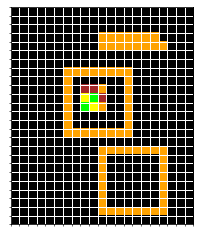

In [253]:
canvas_new_list[0].render()

In [137]:
graphs = OperatorEngine().sample_operator_graph(max_ops_depth=1)

In [138]:
graphs

[OrderedDict([('0$OUT', '@IDENTITY 0$IN'),
              ('1$OUT', '@IDENTITY 0$OUT^$SELECTOR_PATTERN'),
              ('2$OUT', '@IDENTITY 1$OUT^$SELECTOR_PATTERN')]),
 OrderedDict([('0$OUT', '@IDENTITY 0$IN'),
              ('1$OUT', '@IDENTITY 0$OUT^$SELECTOR_PATTERN'),
              ('2$OUT', '@IDENTITY 1$OUT^$SELECTOR_ALL')]),
 OrderedDict([('0$OUT', '@IDENTITY 0$IN'),
              ('1$OUT', '@IDENTITY 0$OUT^$SELECTOR_PATTERN'),
              ('2$OUT', '@IDENTITY 1$OUT^$SELECTOR_EXTREME')]),
 OrderedDict([('0$OUT', '@IDENTITY 0$IN'),
              ('1$OUT', '@IDENTITY 0$OUT^$SELECTOR_PATTERN'),
              ('2$OUT', '@IDENTITY 1$OUT^$SELECTOR_WHOLE')]),
 OrderedDict([('0$OUT', '@IDENTITY 0$IN'),
              ('1$OUT', '@IDENTITY 0$OUT^$SELECTOR_ALL'),
              ('2$OUT', '@IDENTITY 1$OUT^$SELECTOR_PATTERN')]),
 OrderedDict([('0$OUT', '@IDENTITY 0$IN'),
              ('1$OUT', '@IDENTITY 0$OUT^$SELECTOR_ALL'),
              ('2$OUT', '@IDENTITY 1$OUT^$SELECTOR_ALL')]),
 Ord

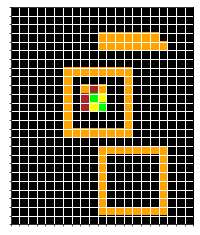

In [141]:
task_dict1 = demo_dataset.sample_single_canvas_by_core_edges(OrderedDict([(('obj_0', 'obj_1'), 'IsInside'), 
                                                            (('obj_2', 'obj_1'), 'SameAll'), 
                                                            (('obj_2', 'obj_3'), 'SameCol')]))
canvas1 = Canvas(repre_dict=task_dict1)

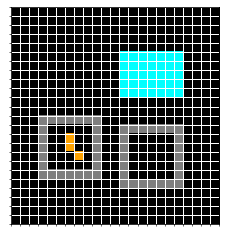

In [142]:
task_dict2 = demo_dataset.sample_single_canvas_by_core_edges(OrderedDict([(('obj_0', 'obj_1'), 'IsInside'), 
                                                            (('obj_2', 'obj_1'), 'SameAll'), 
                                                            (('obj_2', 'obj_3'), 'SameCol')]))
canvas2 = Canvas(repre_dict=task_dict2)

In [183]:
# rotate the whole canvas!

In [ ]:
def operate_rotate_whole(canvas_list):
    pass

In [185]:
_rotate_whole(canvas1)

In [145]:
OperatorEngine().select_by_common_referred_patterns([canvas1, canvas2])

[[['obj_2', 'obj_1'], ['obj_2', 'obj_1']],
 [['obj_0'], ['obj_0']],
 [['obj_2', 'obj_3'], ['obj_2', 'obj_3']]]

In [18]:
# load operators, and generate sample outputs!

### BabyARC in Actions: Generate Outputs

In [19]:
# generate a full example with BabyARC!